# Import Libraries

In [ ]:
# !pip install --quiet --upgrade tensorflow-federated
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff



SEED = 0
tf.random.set_seed(SEED)
np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [ ]:
from tensorflow import keras
from keras.metrics import BinaryAccuracy, Precision, Recall
from keras import layers

from sklearn.model_selection import GroupShuffleSplit

# Load Data


In [ ]:
path = "/content/drive/MyDrive/Thesis/Datasets/Turbofan_Dataset/final_datasets_normalized/"

In [ ]:
# Load data and drop irrelevant columns

alice_set = pd.read_csv(path + "TRAINING_SET_1.csv")
bob_set = pd.read_csv(path + "TRAINING_SET_2.csv")

test_set = pd.read_csv(path + "TEST_SET_FULL.csv")


drop_cols = ["cycle","setting3","s1","s5","s10","s16","s18","s19","RUL"]
corr_cols = ["s11","s4","s15","s17","s2","s3","s8","s13","s9","s14","s12","s7","s20"]
feature_cols = ['cycle_norm', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
prediction_col = 'fail_30'

alice_set = alice_set.drop(drop_cols, axis=1)
bob_set = bob_set.drop(drop_cols, axis=1)

test_set = test_set.drop(drop_cols, axis=1)

In [ ]:
# Move cycle_norm column first for convenience

column_to_move = alice_set.pop("cycle_norm")
alice_set.insert(0, "cycle_norm", column_to_move)
column_to_move = bob_set.pop("cycle_norm")
bob_set.insert(0, "cycle_norm", column_to_move)

column_to_move = test_set.pop("cycle_norm")
test_set.insert(0, "cycle_norm", column_to_move)

In [ ]:
X_alice = alice_set.iloc[:, 0:-1].to_numpy()
y_alice = alice_set.iloc[:, -1].to_numpy()

X_bob = bob_set.iloc[:, 0:-1].to_numpy()
y_bob = bob_set.iloc[:, -1].to_numpy()

X_test = test_set.iloc[:, 0:-1].to_numpy()
y_test = test_set.iloc[:, -1].to_numpy()

# Hyperparameters

In [ ]:
# BATCH_SIZE = 16
# GLOBAL_EPOCHS = 10
# LOCAL_EPOCHS = 25

BATCH_SIZE = 32
GLOBAL_EPOCHS = 10
LOCAL_EPOCHS = 5

# Federated Dataset

In [ ]:
# Use 80% for training and 20% for validation
alice_split = round(X_alice.shape[0] * 0.8)
bob_split = round(X_bob.shape[0] * 0.8)

In [ ]:
np.concatenate([X_alice[alice_split:],X_bob[bob_split:]]).shape

(4126, 19)

In [ ]:
np.concatenate([y_alice[alice_split:],y_bob[bob_split:]]).shape

(4126,)

In [ ]:
train_data, test_data, val_data = [], [], []

temp_dataset = tf.data.Dataset.from_tensor_slices((X_alice[:alice_split], y_alice[:alice_split])).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)
temp_dataset = tf.data.Dataset.from_tensor_slices((X_bob[:bob_split], y_bob[:bob_split])).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)


temp_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data.append(temp_dataset.batch(1))

X_val = np.concatenate([X_alice[alice_split:],X_bob[bob_split:]])
y_val = np.concatenate([y_alice[alice_split:],y_bob[bob_split:]])

temp_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data.append(temp_dataset.batch(BATCH_SIZE))


In [ ]:
test_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>]

In [ ]:
val_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>]

# Define model


In [ ]:
def input_spec():
    return (
        tf.TensorSpec([None, 19], tf.float64),
        tf.TensorSpec([None], tf.int64)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(19)),                                       
        tf.keras.layers.Dense(64, activation="relu"),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation="relu"),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[BinaryAccuracy(), Precision(), Recall()])

# Training

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    # server_optimizer_fn=lambda: tf.keras.optimizers.SGD( learning_rate=0.1)
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate= 0.1)

)

state = trainer.initialize()
train_hist = []
losses = []
accs = []

val_losses = []
val_accs = []
for i in range(GLOBAL_EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)
    losses.append(metrics['train']['loss'])
    accs.append(metrics['train']['binary_accuracy'])

    val_metrics = evaluator(state.model, val_data)
    val_losses.append(val_metrics['eval']['loss'])
    val_accs.append(val_metrics['eval']['binary_accuracy'])

    print(f"\rRun {i+1}/{GLOBAL_EPOCHS} _ loss={metrics['train']['loss']} _ acc={metrics['train']['binary_accuracy']}")

Run 1/10 _ loss=0.286903977394104 _ acc=0.8889886140823364
Run 2/10 _ loss=0.19323119521141052 _ acc=0.9262587428092957
Run 3/10 _ loss=0.3841160237789154 _ acc=0.9222381114959717
Run 4/10 _ loss=0.1770411878824234 _ acc=0.9430117011070251
Run 5/10 _ loss=0.13424909114837646 _ acc=0.9459188580513
Run 6/10 _ loss=0.12116210162639618 _ acc=0.9481796622276306
Run 7/10 _ loss=0.11784256994724274 _ acc=0.9501549601554871
Run 8/10 _ loss=0.1165609136223793 _ acc=0.9518638253211975
Run 9/10 _ loss=0.1214861050248146 _ acc=0.9513869881629944
Run 10/10 _ loss=0.115979865193367 _ acc=0.9519800543785095


In [ ]:
train_metrics = evaluator(state.model, train_data)
train_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.9546548),
                           ('precision', 0.84815705),
                           ('recall', 0.85259765),
                           ('loss', 0.10885505),
                           ('num_examples', 82525),
                           ('num_batches', 1291)]))])

In [ ]:
train_metrics['eval']

OrderedDict([('binary_accuracy', 0.9546548),
             ('precision', 0.84815705),
             ('recall', 0.85259765),
             ('loss', 0.10885505),
             ('num_examples', 82525),
             ('num_batches', 1291)])

In [ ]:
test_metrics = evaluator(state.model, test_data)
test_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.98518634),
                           ('precision', 0.74642855),
                           ('recall', 0.6295181),
                           ('loss', 0.04259714),
                           ('num_examples', 13096),
                           ('num_batches', 13096)]))])

In [ ]:
def plot(train, valid, name):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(train)+1), train, label='train')
    plt.plot(range(1, len(valid)+1), valid, label='validate')
    plt.xlabel('Rounds')
    plt.ylabel(name)
    plt.legend()
    plt.show()

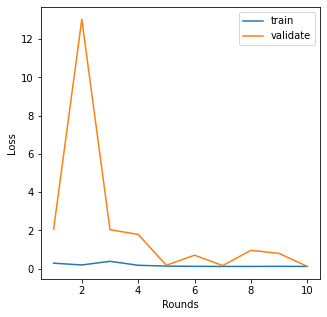

In [ ]:
plot(losses, val_losses, 'Loss')

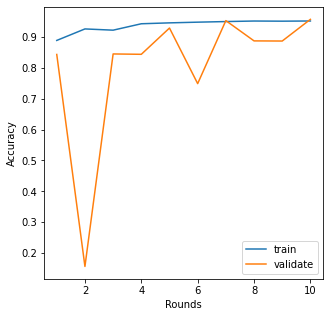

In [ ]:
plot(accs, val_accs, 'Accuracy')

In [ ]:
type(state.model)

tensorflow_federated.python.learning.model_utils.ModelWeights